In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
from datetime import timedelta

загрузка данных

In [2]:
data = pd.read_csv('com_data/com_fixed_data_20250502_035859_619.csv')
short_data = data[(data['Timestamp'] > '2025-05-02 03:59:00') & (data['Timestamp'] < '2025-05-02 04:10:05')]

In [3]:
date = short_data['Timestamp']
signal = short_data['COM_Data']
peaks = short_data['Peaks']

In [4]:
def calculate_hrv_sliding_window(df: pd.DataFrame, window_size_minutes: int = 1):
    """
    Вычисляет частоту сердечных сокращений (ЧСС) и вариабельность сердечного ритма (ВСР - RMSSD)
    с использованием скользящего окна.

    Args:

        df: Входной DataFrame с индексом datetime и столбцом 'peaks'.

            Столбец 'peaks' должен содержать логические значения (True/False), указывающие на наличие пика в данный момент времени.

            Строки с отсутствующими точками данных в идеале должны отсутствовать в индексе.

        window_size_minutes: Размер скользящего окна в минутах.

    Returns:

        DataFrame со столбцами 'дата-время', 'ЧСС', 'ВСР'.

        'дата-время' - это центральная метка времени окна.

    """

    window_size = timedelta(minutes=window_size_minutes)

    results = []

    # Ensure df has a datetime index

    if not isinstance(df.index, pd.DatetimeIndex):
        # Attempt to convert if a timestamp column exists, otherwise raise error

        timestamp_col = None

        for col in df.columns:
            if pd.api.types.is_datetime64_any_dtype(df[col]):
                timestamp_col = col

                break

            # Also check for common string names that might be timestamps

            if col.lower() in ["time", "timestamp"]:
                try:
                    df[col] = pd.to_datetime(df[col])

                    timestamp_col = col

                    break

                except:
                    pass  # Not a datetime column

        if timestamp_col:
            df = df.set_index(timestamp_col).sort_index()

        else:
            raise TypeError(
                "Input DataFrame must have a DatetimeIndex or a column convertible to DatetimeIndex."
            )

    # Ensure 'peaks' column exists and contains boolean values

    if "peaks" not in df.columns:
        raise ValueError("Input DataFrame must contain a 'peaks' column.")

    if not pd.api.types.is_bool_dtype(df["peaks"]):
        raise ValueError("'peaks' column must contain boolean values (True/False).")

    peak_timestamps = df.index[df["peaks"]]  # Get timestamps where peaks are True

    # Determine the start and end times for the sliding windows

    # Start from the earliest data point, end when the window extends beyond the latest data point

    start_time = df.index.min()

    end_time = df.index.max()

    # Slide the window by a fixed step, e.g., 1 second

    slide_step = timedelta(seconds=1)

    current_window_start = start_time

    # Iterate until the end of the window exceeds the latest data point

    # The condition ensures the window's end is within or at the latest data point

    while current_window_start + window_size <= end_time:
        current_window_end = current_window_start + window_size

        window_center = current_window_start + window_size / 2

        # Filter data points within the current window based on index

        window_data = df.loc[current_window_start:current_window_end]

        # Filter peak timestamps within the current window

        window_peaks = peak_timestamps[
            (peak_timestamps >= current_window_start)
            & (peak_timestamps < current_window_end)
        ]

        hr = np.nan

        hrv_rmssd = np.nan

        # Calculate effective duration within the window

        # This accounts for gaps in the data index within the window

        effective_duration_seconds = 0

        if not window_data.empty:
            # The effective duration is the time span covered by the data points in the window.

            # If data points are missing, the span between the min and max index in the window_data

            # represents the actual time covered by the existing data within that window.

            if len(window_data.index) > 1:
                effective_duration_seconds = (
                    window_data.index.max() - window_data.index.min()
                ).total_seconds()

            elif len(window_data.index) == 1:
                # If only one data point, effective duration is effectively 0 for rate calculation

                effective_duration_seconds = 0

            else:
                effective_duration_seconds = (
                    0  # Should be covered by window_data.empty check
                )

        # Calculate HR (ЧСС)

        num_peaks = len(window_peaks)

        if num_peaks >= 2:
            # Calculate intervals between consecutive peaks (RR intervals)

            # Ensure peaks are sorted for diff calculation

            sorted_window_peaks = window_peaks.sort_values()

            rr_intervals_seconds = (
                sorted_window_peaks.to_series().diff().dropna().dt.total_seconds()
            )  # in seconds

            if len(rr_intervals_seconds) > 0:
                average_rr_interval_seconds = rr_intervals_seconds.mean()

                if average_rr_interval_seconds > 0:
                    hr = 60.0 / average_rr_interval_seconds

                else:
                    hr = np.nan

            else:
                hr = np.nan

        else:
            hr = np.nan  # Not enough peaks to calculate HR

        # Calculate HRV (ВСР) - RMSSD

        if num_peaks >= 2:
            # Calculate intervals between consecutive peaks (RR intervals)

            # Ensure peaks are sorted for diff calculation

            sorted_window_peaks = window_peaks.sort_values()

            rr_intervals = (
                sorted_window_peaks.to_series().diff().dropna().dt.total_seconds()
                * 1000
            )  # in milliseconds

            if len(rr_intervals) > 0:
                # Calculate squared differences of successive RR intervals

                squared_diffs = np.diff(rr_intervals) ** 2

                if len(squared_diffs) > 0:
                    # Calculate RMSSD

                    mean_squared_diffs = np.mean(squared_diffs)

                    hrv_rmssd = np.sqrt(mean_squared_diffs)

        results.append({"date": window_center, "HR": hr, "HRV": hrv_rmssd})

        # Move the window forward

        current_window_start += slide_step

    results_df = pd.DataFrame(results)

    return results_df


In [5]:
df = pd.DataFrame()
df['Timestamp'] = date
df['peaks'] = peaks
result_df = calculate_hrv_sliding_window(df=df)

In [6]:
result_df.head()

,date,HR,HRV
0,2025-05-02 03:59:30.002,100.752284,237.234871
1,2025-05-02 03:59:31.002,100.858982,236.979712
2,2025-05-02 03:59:32.002,100.874586,238.058688
3,2025-05-02 03:59:33.002,100.848811,233.011466
4,2025-05-02 03:59:34.002,101.550335,217.678314


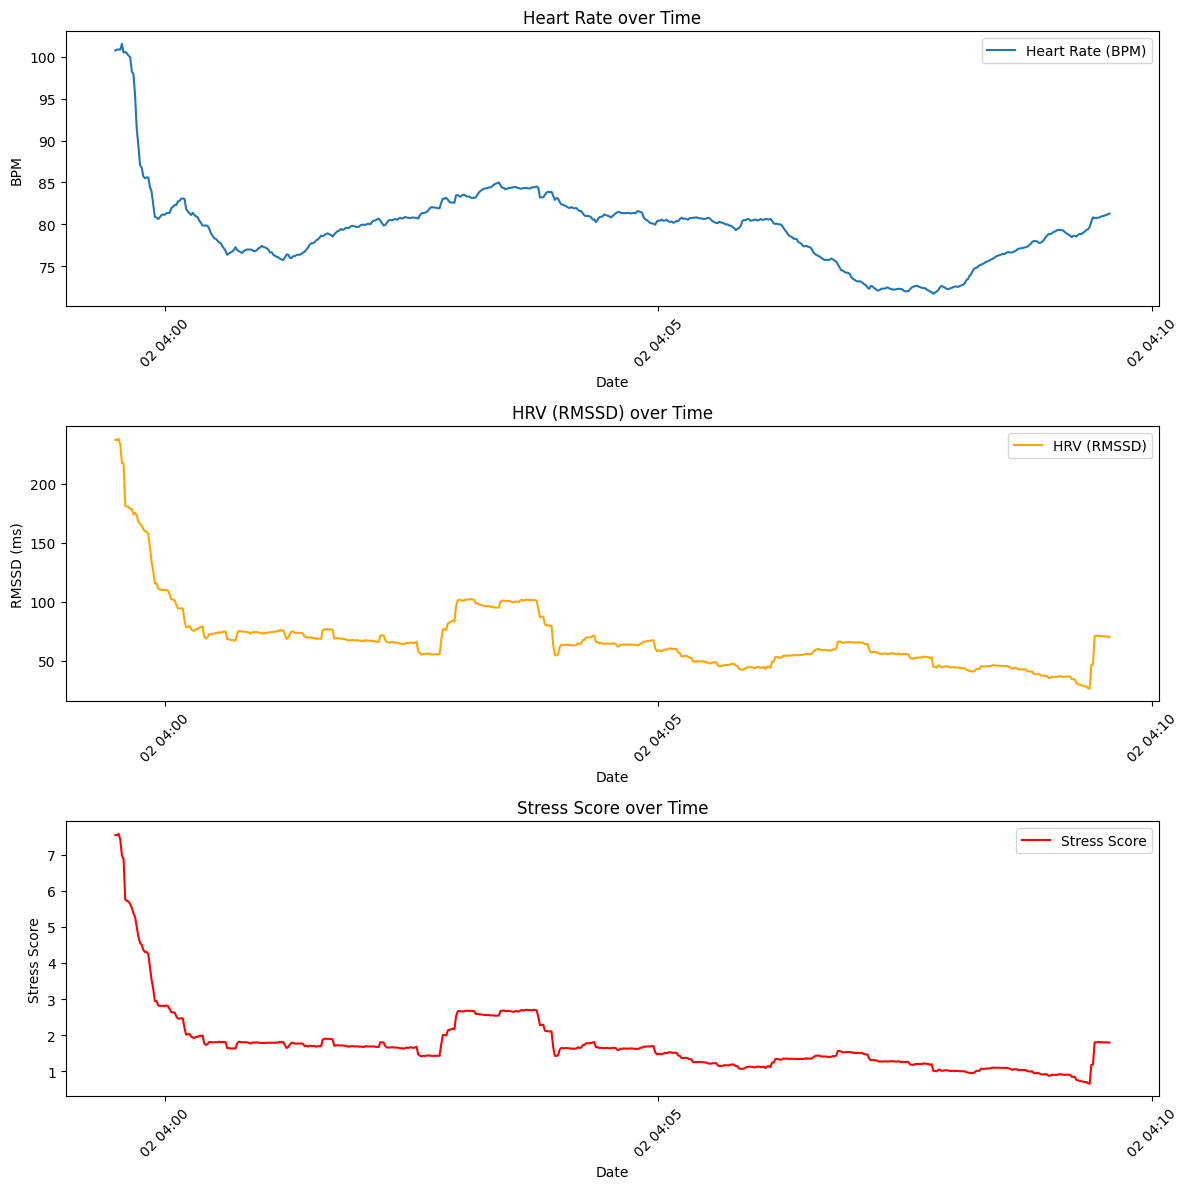

In [7]:
# User provided data
weight_kg = 56
gender = "male"

# Normalizing coefficient based on gender
if gender == "male":
    K = 0.8244e-4
elif gender == "female":
    K = 0.9357e-4
else:
    raise ValueError("Invalid gender. Must be 'male' or 'female'.")

# Calculate stress score
result_df['stress_score'] = result_df['HR'] * result_df['HRV'] * (weight_kg ** (1/3)) * K

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot HR
axes[0].plot(result_df['date'], result_df['HR'], label='Heart Rate (BPM)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('BPM')
axes[0].set_title('Heart Rate over Time')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Plot HRV
axes[1].plot(result_df['date'], result_df['HRV'], label='HRV (RMSSD)', color='orange')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('RMSSD (ms)')
axes[1].set_title('HRV (RMSSD) over Time')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# Plot Stress Score
axes[2].plot(result_df['date'], result_df['stress_score'], label='Stress Score', color='red')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Stress Score')
axes[2].set_title('Stress Score over Time')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


In [12]:
data = pd.read_csv('com_data/com_fixed_data_20250502_035859_619.csv')
short_data = data[(data['Timestamp'] > '2025-05-02 03:59:00') & (data['Timestamp'] < '2025-05-02 04:00:05')].reset_index(drop=True)

date = short_data['Timestamp']
signal = short_data['COM_Data']
peaks = short_data['Peaks']

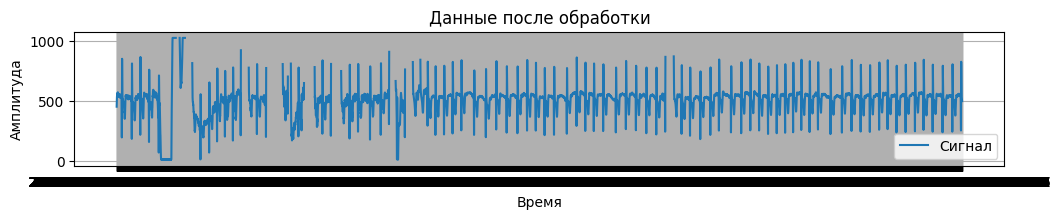

In [13]:


plt.figure(figsize=(12, 8))
plt.subplot(414)
plt.plot(date, signal, label="Сигнал")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Данные после обработки")
plt.legend()
plt.grid(True)
plt.show()